# Vin2param

Задача вроде головоломки, рассмотренной на семинаре, могут встретиться и на практике. Ближайшим аналогом такой задачи в Avito является сервис vin2param. С помощью этого сервиса можно упростить подачу объявлений в категории Авто. При подаче объявления в этой категории пользователя первым делом просят ввести VIN (Vehicle identification number) своего автомобиля, а потом с помощью vin2param заполняют параметры (марка, модель, поколение, объем двигателя и пр.). Конечно, можно было бы попробовать реализовать такой сервис с помощью набора правил, подобного указанному на картинке:

<img src=https://ucarecdn.com/015d7ece-a2cf-415e-990d-70a19e8a7324/ style="width: 600px;">

Но на деле такой подход гораздо сложнее: правила формирования VIN разнятся от производителя к производителю, каждый производитель выпускает новые модели, которые кодируются новыми символами, да и пользователи могут ошибиться при вводе VIN. Решение с помощью машинного обучения получается надёжнее и проще в поддержке.

Так как данные VIN являются очень ценной информацией, выложить реальный датасет в открытый доступ нельзя. В качестве домашнего задания предлагается решить такую задачу на синтетических данных. Вам необходимо научиться предсказывать параметры автомобиля по последовательности символов в VIN.

In [1]:
import time 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import string
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ssl


from sklearn.preprocessing import OneHotEncoder

ssl._create_default_https_context = ssl._create_unverified_context
%config Completer.use_jedi = False

In [2]:
def plot_progress(train_losses, train_accs, test_loss, test_accs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_accs, label='train accuracy')
    ax2.plot(test_accs, label='test accuracy')
    ax2.plot(np.ones_like(accs_train), '--', label='100% accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()
    print(f'Loss train: {round(train_losses[-1], 4)}, accuracy train: {round(train_accs[-1], 3)},\
    loss test: {round(test_loss[-1], 4)}, accuracy test: {round(test_accs[-1], 3)}')
    
    
    
def get_vin2index(data):
    return  {l: i for i, l in enumerate(set(''.join(data)))}


def vin_to_tensor(vin):
        return torch.tensor([vocab_vin2index[l] for l in vin])
    
    
def vin_to_numpy(vin):
        return np.array([vocab_vin2index[l] for l in vin])
    
def get_vocab(data):
    return  {l: i for i, l in enumerate(set('**'.join(data).split('**')))}

In [3]:
# Создадим  класс конструирующий датасет для нашей задачи. 
class VINDataset(Dataset):
    
    def __init__(self, vin, y_train, vocab_vin2index):
        self.vin = vin  # объекты
        self.y_train = y_train
        self.vocab_vin2index = vocab_vin2index
        
    def __len__(self):
        return len(self.vin)  # количество объектов
    
    def __getitem__(self, idx):
        x = self.vin_to_tensor(self.vin[idx]).long()  # преобразуем один объект в тензор индексов, тип long()        
        y = torch.tensor(self.y_train[idx]).float()
        
        return x, y #torch.hstack((y_brand, y_model, y_color))
    
    @staticmethod
    def vin_to_tensor(vin):
        return torch.tensor([vocab_vin2index[l] for l in vin])
    
    @staticmethod
    def get_vin2index(data):
        return  {l: i for i, l in enumerate(set(''.join(data)))}

In [4]:
# Создаем класс под НС типа LSTM
# TODO: почистить это ячейку
class VimLSTM(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, embedding_dim, out_size, bidirectional=False, num_layer=1):
    
        super(VimLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size   
        self.embedding_dim = embedding_dim
        self.out_size = out_size
        self.num_layer = num_layer
        self.multiplier = 2 if bidirectional else 1 
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            bidirectional=bidirectional,
            bias=True,
            num_layers=self.num_layer
        )
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(self.multiplier * hidden_size, self.multiplier * hidden_size)
        self.softmax = nn.Softmax(dim=1)
        
        self.linear1 = nn.Linear(self.multiplier * hidden_size, n_class_brand) 
        self.linear2 = nn.Linear(self.multiplier * hidden_size, n_class_model) 
        self.linear3 = nn.Linear(self.multiplier * hidden_size, n_class_color) 


    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x, _ = x.max(dim=-2)
        x = self.linear(x)
        
        x_brand = self.linear1(x)
        x_model = self.linear2(x)
        x_color = self.linear3(x)
        
        return x_brand, x_model, x_color

In [5]:
# Читаем данные
x_train, y_train = pd.read_csv('vins_train.csv')['VIN'], pd.read_csv('vins_train.csv')[['CarBrand', 'CarModel', 'Color']]
x_test = pd.read_csv('vins_test.csv')['VIN']

# Находим макс. длину VIN и добиваем все значения до нее
max_lenght = max(x_test.apply(lambda x: len(x)).max(), x_train.apply(lambda x: len(x)).max())

x_train = x_train.apply(lambda x: x.ljust(max_lenght, '-'))
#x_test = x_test.apply(lambda x: x.ljust(max_lenght, '-'))

# Находим кол-во классов для каждого параметра
n_class_brand = y_train['CarBrand'].nunique()
n_class_model = y_train['CarModel'].nunique()
n_class_color = y_train['Color'].nunique()
out_size = n_class_brand + n_class_model + n_class_color

# Составляем словарь для VIN символом
vocab_vin2index = get_vin2index(x_train)

# Переводим в OHE ответы модели
enc = OneHotEncoder(sparse=False)
y_train  = enc.fit_transform(y_train[['CarBrand', 'CarModel', 'Color']])

vocab_brand = dict(zip(enc.categories_[0], [i for i in range(len(enc.categories_[0]))]))
vocab_model = dict(zip(enc.categories_[1], [i for i in range(len(enc.categories_[1]))]))
vocab_color = dict(zip(enc.categories_[2], [i for i in range(len(enc.categories_[2]))]))

r_vocab_brand = dict(zip(vocab_brand.values(), vocab_brand.keys()))
r_vocab_model = dict(zip(vocab_model.values(), vocab_model.keys()))
r_vocab_color = dict(zip(vocab_color.values(), vocab_color.keys()))

# x_train df -> np.array
x_train = x_train.values

In [6]:
# Поделим на трейн и тест
x_train_, x_val, y_train_, y_val = train_test_split(
    x_train, y_train, test_size=0.15, 
)

# Создадим датасет и даталоадер
train_dataset = VINDataset(vin=x_train_, y_train=y_train_, vocab_vin2index=vocab_vin2index)
test_dataset = VINDataset(vin=x_val, y_train=y_val, vocab_vin2index=vocab_vin2index)

train_sequence_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_sequence_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [7]:
# Создаем модель
model = VimLSTM(
    vocab_size=len(vocab_vin2index),
    embedding_dim=64,
    hidden_size=64,
    num_layer=1,
    bidirectional=False,
    out_size=n_class_brand + n_class_model + n_class_color
)

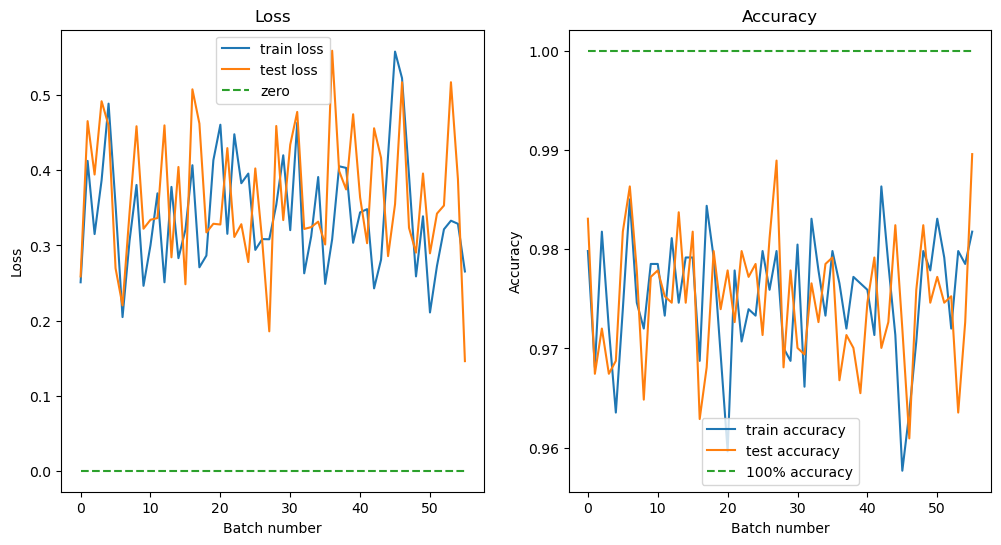

Loss train: 0.2654, accuracy train: 0.982,    loss test: 0.1459, accuracy test: 0.99


In [82]:
# Обучаем модель отдельно от инициализации, чтобы можно было доучить 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

brand_head_loss_fn = nn.CrossEntropyLoss()
model_head_loss_fn = nn.CrossEntropyLoss()
color_head_loss_fn = nn.CrossEntropyLoss()

n_epochs = 1

train_losses = []

accs_brand = []
accs_model = []
accs_color = []
accs_train = []

test_losses = []

accs_brand_test = []
accs_model_test = []
accs_color_test = []
accs_test = []
j = 0
for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:
        j += 1
        model.train()
        preds_brand, preds_model, preds_color = model(x_train)
        
        train_loss_brand = brand_head_loss_fn(preds_brand, y_train[:, :n_class_brand]).mean()
        train_loss_model = model_head_loss_fn(preds_model, y_train[:, n_class_brand: n_class_brand + n_class_model]).mean()
        train_loss_color = color_head_loss_fn(preds_color, y_train[:, n_class_brand + n_class_model:]).mean()
        
        total_loss = train_loss_brand + train_loss_model + train_loss_color
        
        train_acc_brand = (preds_brand.argmax(dim=1) == y_train[:, :n_class_brand].argmax(dim=1)).float().mean()
        train_acc_model = (preds_model.argmax(dim=1) == y_train[:, n_class_brand: n_class_brand + n_class_model].argmax(dim=1)).float().mean()
        train_acc_color = (preds_color.argmax(dim=1) == y_train[:, n_class_brand + n_class_model:].argmax(dim=1)).float().mean()
        
        optimizer.zero_grad()
        total_loss.backward()
        
        optimizer.step()
        model.eval()
        
        x_test, y_test = next(iter(test_sequence_dataloader))
        
        preds_brand_test, preds_model_test, preds_color_test = model(x_test)
        
        test_loss_brand = brand_head_loss_fn(preds_brand_test, y_test[:, :n_class_brand]).mean()
        test_loss_model = model_head_loss_fn(preds_model_test, y_test[:, n_class_brand: n_class_brand + n_class_model]).mean()
        test_loss_color = color_head_loss_fn(preds_color_test, y_test[:, n_class_brand + n_class_model:]).mean()
        
        total_loss_test = test_loss_brand + test_loss_model + test_loss_color
        
        test_acc_brand = (preds_brand_test.argmax(dim=1) == y_test[:, :n_class_brand].argmax(dim=1)).float().mean()
        test_acc_model = (preds_model_test.argmax(dim=1) == y_test[:, n_class_brand: n_class_brand + n_class_model].argmax(dim=1)).float().mean()
        test_acc_color = (preds_color_test.argmax(dim=1) == y_test[:, n_class_brand + n_class_model:].argmax(dim=1)).float().mean()
        
        if j % 10 == 0:
            train_losses.append(total_loss.item())
            accs_train.append((train_acc_brand.item() + train_acc_model.item() + train_acc_color.item()) / 3)

            test_losses.append(total_loss_test.item())
            accs_test.append((test_acc_brand.item() + test_acc_model.item() + test_acc_color.item()) / 3)


            plot_progress(train_losses, accs_train, test_losses, accs_test)


In [83]:
# Подгрузим тест и преобразуем его для подачи в модель
x_test_0 = pd.read_csv('vins_test.csv')['VIN']
x_test_0 = x_test_0.apply(lambda x: x.ljust(max_lenght, '-'))
x_test_0 = x_test_0.values
x_test_0 = torch.tensor(list(map(vin_to_numpy, x_test_0)))

In [84]:
# Получим предсказание и преобразуем к начальной форме
model.eval()
y_brand_test, y_model_test, y_color_test = model(x_test_0)

y_brand_test = y_brand_test.argmax(dim=1)
y_model_test = y_model_test.argmax(dim=1)
y_color_test = y_color_test.argmax(dim=1)

y_brand_test = [r_vocab_brand[x] for x in y_brand_test.numpy()]
y_model_test = [r_vocab_model[x] for x in y_model_test.numpy()]
y_color_test = [r_vocab_color[x] for x in y_color_test.numpy()]

In [85]:
# Сохраняем результаты
predictions = pd.DataFrame(data=np.vstack((y_brand_test, y_model_test, y_color_test)).T,
                           columns=['CarBrand', 'CarModel', 'Color'])

predictions.to_csv('submission.csv', index=False)

predictions

,CarBrand,CarModel,Color
0,ВАЗ (LADA),2114 Samara,Серый
1,ВАЗ (LADA),2110,Белый
2,ВАЗ (LADA),4x4 (Нива),Красный
3,ВАЗ (LADA),2110,Бежевый
4,ВАЗ (LADA),21099,Чёрный
...,...,...,...
19995,ВАЗ (LADA),2105,Белый
19996,ВАЗ (LADA),2113 Samara,Серебряный
19997,ВАЗ (LADA),21099,Зелёный
19998,Opel,Vivaro,Белый
